In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = True
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

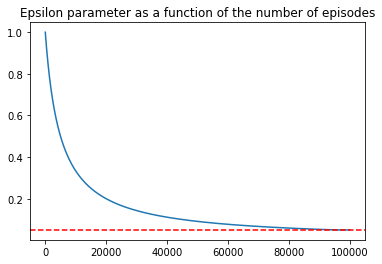

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 19

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -16.526669041494646
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9617 Discounted reward:  -18.17965333695701
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.9436 Discounted reward:  -18.822377030963704
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.9261 Discounted reward:  -12.482282536290048
Episode: 500. Elapsed time  0.36  minuts. epsilon 0.9093 Discounted reward:  -18.61718004102604
Episode: 600. Elapsed time  0.46  minuts. epsilon 0.893 Discounted reward:  -17.552213076694876
Episode: 700. Elapsed time  0.56  minuts. epsilon 0.8773 Discounted reward:  -21.54810163394497
Episode: 800. Elapsed time  0.67  minuts. epsilon 0.8622 Discounted reward:  -14.690827815606925
Episode: 900. Elapsed time  0.78  minuts. epsilon 0.8476 Discounted reward:  -15.46780784421464
Episode: 1000. Elapsed time  0.91  minuts. epsilon 0.8335 Discounted reward:  -19.825421612659593
Episode: 1100. Elapsed time  1.03 

Episode: 8600. Elapsed time  19.87  minuts. epsilon 0.3677 Discounted reward:  -6.137471697874836
Episode: 8700. Elapsed time  20.18  minuts. epsilon 0.365 Discounted reward:  -2.809884348193944
Episode: 8800. Elapsed time  20.49  minuts. epsilon 0.3623 Discounted reward:  -9.047540927596305
Episode: 8900. Elapsed time  20.84  minuts. epsilon 0.3597 Discounted reward:  -5.337662043169216
Episode: 9000. Elapsed time  21.17  minuts. epsilon 0.3572 Discounted reward:  -7.102423081113789
Episode: 9100. Elapsed time  21.48  minuts. epsilon 0.3546 Discounted reward:  -6.0432385564846305
Episode: 9200. Elapsed time  21.8  minuts. epsilon 0.3521 Discounted reward:  -2.1722380414471423
Episode: 9300. Elapsed time  22.18  minuts. epsilon 0.3497 Discounted reward:  -4.018919309819648
Episode: 9400. Elapsed time  22.57  minuts. epsilon 0.3472 Discounted reward:  -4.401352184883644
Episode: 9500. Elapsed time  22.88  minuts. epsilon 0.3449 Discounted reward:  -9.237042776545891
Episode: 9600. Elaps

Episode: 16900. Elapsed time  51.32  minuts. epsilon 0.2283 Discounted reward:  -4.059118250068665
Episode: 17000. Elapsed time  51.74  minuts. epsilon 0.2273 Discounted reward:  -1.6146732457568527
Episode: 17100. Elapsed time  52.12  minuts. epsilon 0.2263 Discounted reward:  -5.189968794599782
Episode: 17200. Elapsed time  52.57  minuts. epsilon 0.2252 Discounted reward:  -1.7580430509047489
Episode: 17300. Elapsed time  52.98  minuts. epsilon 0.2242 Discounted reward:  -3.695425304289162
Episode: 17400. Elapsed time  53.37  minuts. epsilon 0.2232 Discounted reward:  -4.284223759504902
Episode: 17500. Elapsed time  53.76  minuts. epsilon 0.2222 Discounted reward:  -0.9435529681592214
Episode: 17600. Elapsed time  54.25  minuts. epsilon 0.2212 Discounted reward:  -1.5537198983568348
Episode: 17700. Elapsed time  54.69  minuts. epsilon 0.2203 Discounted reward:  -5.016553444549938
Episode: 17800. Elapsed time  55.07  minuts. epsilon 0.2193 Discounted reward:  -1.0893101380699461
Episo

Episode: 25200. Elapsed time  86.66  minuts. epsilon 0.1656 Discounted reward:  -4.433367578490401
Episode: 25300. Elapsed time  87.06  minuts. epsilon 0.165 Discounted reward:  -2.6141661344526375
Episode: 25400. Elapsed time  87.5  minuts. epsilon 0.1645 Discounted reward:  -1.5855053005554527
Episode: 25500. Elapsed time  87.9  minuts. epsilon 0.1639 Discounted reward:  -2.1678930925406656
Episode: 25600. Elapsed time  88.3  minuts. epsilon 0.1634 Discounted reward:  -4.421801263170469
Episode: 25700. Elapsed time  88.7  minuts. epsilon 0.1629 Discounted reward:  -0.7655246512135144
Episode: 25800. Elapsed time  89.18  minuts. epsilon 0.1623 Discounted reward:  -1.7540483000060711
Episode: 25900. Elapsed time  89.67  minuts. epsilon 0.1618 Discounted reward:  -3.0524558071160732
Episode: 26000. Elapsed time  90.1  minuts. epsilon 0.1613 Discounted reward:  -0.39603180414445804
Episode: 26100. Elapsed time  90.56  minuts. epsilon 0.1608 Discounted reward:  -1.6825535952516693
Episode

Episode: 33400. Elapsed time  123.59  minuts. epsilon 0.1302 Discounted reward:  -1.574050324008399
Episode: 33500. Elapsed time  124.02  minuts. epsilon 0.1299 Discounted reward:  -1.3536857317039008
Episode: 33600. Elapsed time  124.46  minuts. epsilon 0.1295 Discounted reward:  -1.5020434411310992
Episode: 33700. Elapsed time  124.97  minuts. epsilon 0.1292 Discounted reward:  -0.5827923514961165
Episode: 33800. Elapsed time  125.41  minuts. epsilon 0.1289 Discounted reward:  -2.1633790213444986
Episode: 33900. Elapsed time  125.88  minuts. epsilon 0.1285 Discounted reward:  -3.2991175437094244
Episode: 34000. Elapsed time  126.37  minuts. epsilon 0.1282 Discounted reward:  -2.777338749341757
Episode: 34100. Elapsed time  126.85  minuts. epsilon 0.1279 Discounted reward:  -1.0311808174283732
Episode: 34200. Elapsed time  127.27  minuts. epsilon 0.1276 Discounted reward:  -1.2057265699756803
Episode: 34300. Elapsed time  127.7  minuts. epsilon 0.1272 Discounted reward:  -2.8966086709

Episode: 41600. Elapsed time  161.06  minuts. epsilon 0.1073 Discounted reward:  -0.19304062248977605
Episode: 41700. Elapsed time  161.5  minuts. epsilon 0.1071 Discounted reward:  -3.779498346633559
Episode: 41800. Elapsed time  161.94  minuts. epsilon 0.1068 Discounted reward:  -0.7428081113449907
Episode: 41900. Elapsed time  162.4  minuts. epsilon 0.1066 Discounted reward:  -0.007363686003001432
Episode: 42000. Elapsed time  162.83  minuts. epsilon 0.1064 Discounted reward:  -0.38344819536070257
Episode: 42100. Elapsed time  163.27  minuts. epsilon 0.1062 Discounted reward:  -0.7957161434313795
Episode: 42200. Elapsed time  163.75  minuts. epsilon 0.1059 Discounted reward:  -3.11447382569913
Episode: 42300. Elapsed time  164.18  minuts. epsilon 0.1057 Discounted reward:  -2.1105491277752253
Episode: 42400. Elapsed time  164.61  minuts. epsilon 0.1055 Discounted reward:  -0.8851908861379757
Episode: 42500. Elapsed time  165.08  minuts. epsilon 0.1053 Discounted reward:  -1.75552586

Episode: 49800. Elapsed time  199.71  minuts. epsilon 0.0912 Discounted reward:  -2.332744531350054
Episode: 49900. Elapsed time  200.27  minuts. epsilon 0.0911 Discounted reward:  -1.9803500525640645
Episode: 50000. Elapsed time  200.71  minuts. epsilon 0.0909 Discounted reward:  -1.7561964517245532
Episode: 50100. Elapsed time  201.15  minuts. epsilon 0.0907 Discounted reward:  -1.1835101036607754
Episode: 50200. Elapsed time  201.61  minuts. epsilon 0.0906 Discounted reward:  -0.006864945597114997
Episode: 50300. Elapsed time  202.06  minuts. epsilon 0.0904 Discounted reward:  -4.218044555879523
Episode: 50400. Elapsed time  202.5  minuts. epsilon 0.0903 Discounted reward:  -1.0842681710663415
Episode: 50500. Elapsed time  202.94  minuts. epsilon 0.0901 Discounted reward:  -3.769919737234398
Episode: 50600. Elapsed time  203.38  minuts. epsilon 0.0899 Discounted reward:  -1.1265731623423116
Episode: 50700. Elapsed time  203.83  minuts. epsilon 0.0898 Discounted reward:  -3.141822018

Episode: 58000. Elapsed time  238.85  minuts. epsilon 0.0794 Discounted reward:  -1.9034474072999512
Episode: 58100. Elapsed time  239.3  minuts. epsilon 0.0792 Discounted reward:  -1.0716888556410011
Episode: 58200. Elapsed time  239.75  minuts. epsilon 0.0791 Discounted reward:  -0.008551628278044494
Episode: 58300. Elapsed time  240.25  minuts. epsilon 0.079 Discounted reward:  -0.009018048695576217
Episode: 58400. Elapsed time  240.84  minuts. epsilon 0.0789 Discounted reward:  -0.5476469390951726
Episode: 58500. Elapsed time  241.39  minuts. epsilon 0.0787 Discounted reward:  -0.7291213333402816
Episode: 58600. Elapsed time  241.84  minuts. epsilon 0.0786 Discounted reward:  -0.007688880973974508
Episode: 58700. Elapsed time  242.33  minuts. epsilon 0.0785 Discounted reward:  -2.7751474815030313
Episode: 58800. Elapsed time  242.89  minuts. epsilon 0.0784 Discounted reward:  -1.8057704733086226
Episode: 58900. Elapsed time  243.34  minuts. epsilon 0.0782 Discounted reward:  -0.633

Episode: 66100. Elapsed time  278.29  minuts. epsilon 0.0703 Discounted reward:  -0.8280952897011445
Episode: 66200. Elapsed time  278.88  minuts. epsilon 0.0702 Discounted reward:  -1.0550609488194445
Episode: 66300. Elapsed time  279.41  minuts. epsilon 0.0701 Discounted reward:  -0.00690712790034099
Episode: 66400. Elapsed time  279.92  minuts. epsilon 0.07 Discounted reward:  -0.3834228843047566
Episode: 66500. Elapsed time  280.38  minuts. epsilon 0.0699 Discounted reward:  -0.006068503077704077
Episode: 66600. Elapsed time  280.84  minuts. epsilon 0.0698 Discounted reward:  -0.7373485405859361
Episode: 66700. Elapsed time  281.32  minuts. epsilon 0.0697 Discounted reward:  -0.05233531778172636
Episode: 66800. Elapsed time  281.8  minuts. epsilon 0.0696 Discounted reward:  -0.005097303287666738
Episode: 66900. Elapsed time  282.27  minuts. epsilon 0.0695 Discounted reward:  -0.4750066352399039
Episode: 67000. Elapsed time  282.8  minuts. epsilon 0.0694 Discounted reward:  -1.03685

Episode: 74200. Elapsed time  318.76  minuts. epsilon 0.0631 Discounted reward:  -1.0675431395909978
Episode: 74300. Elapsed time  319.22  minuts. epsilon 0.0631 Discounted reward:  -0.483756410503971
Episode: 74400. Elapsed time  319.69  minuts. epsilon 0.063 Discounted reward:  -1.6900042711055858
Episode: 74500. Elapsed time  320.22  minuts. epsilon 0.0629 Discounted reward:  -1.8497613773173933
Episode: 74600. Elapsed time  320.75  minuts. epsilon 0.0628 Discounted reward:  -0.5173682736410203
Episode: 74700. Elapsed time  321.36  minuts. epsilon 0.0627 Discounted reward:  -0.4394312077926403
Episode: 74800. Elapsed time  321.88  minuts. epsilon 0.0627 Discounted reward:  -0.005045514327867156
Episode: 74900. Elapsed time  322.41  minuts. epsilon 0.0626 Discounted reward:  -0.015820681808579967
Episode: 75000. Elapsed time  322.87  minuts. epsilon 0.0625 Discounted reward:  -1.3474584564536787
Episode: 75100. Elapsed time  323.34  minuts. epsilon 0.0624 Discounted reward:  -1.79106

Episode: 82300. Elapsed time  360.13  minuts. epsilon 0.0573 Discounted reward:  -1.9132368762692264
Episode: 82400. Elapsed time  360.61  minuts. epsilon 0.0572 Discounted reward:  -0.08981551532499092
Episode: 82500. Elapsed time  361.06  minuts. epsilon 0.0571 Discounted reward:  -2.227503280257863
Episode: 82600. Elapsed time  361.57  minuts. epsilon 0.0571 Discounted reward:  -2.578335521276222
Episode: 82700. Elapsed time  362.08  minuts. epsilon 0.057 Discounted reward:  -0.35325121278309374
Episode: 82800. Elapsed time  362.55  minuts. epsilon 0.0569 Discounted reward:  -1.3724375295184486
Episode: 82900. Elapsed time  363.14  minuts. epsilon 0.0569 Discounted reward:  -0.7499344055881384
Episode: 83000. Elapsed time  363.6  minuts. epsilon 0.0568 Discounted reward:  -0.00567788540147772
Episode: 83100. Elapsed time  364.07  minuts. epsilon 0.0568 Discounted reward:  -4.495977548192342
Episode: 83200. Elapsed time  364.63  minuts. epsilon 0.0567 Discounted reward:  -0.338365298

Episode: 90400. Elapsed time  401.08  minuts. epsilon 0.0524 Discounted reward:  -0.10729796585432934
Episode: 90500. Elapsed time  401.59  minuts. epsilon 0.0524 Discounted reward:  -2.074580597785829
Episode: 90600. Elapsed time  402.1  minuts. epsilon 0.0523 Discounted reward:  -1.2966546556812366
Episode: 90700. Elapsed time  402.59  minuts. epsilon 0.0522 Discounted reward:  -2.9642051269920855
Episode: 90800. Elapsed time  403.05  minuts. epsilon 0.0522 Discounted reward:  -0.006247264989100499
Episode: 90900. Elapsed time  403.52  minuts. epsilon 0.0521 Discounted reward:  -0.0042522403668662145
Episode: 91000. Elapsed time  404.05  minuts. epsilon 0.0521 Discounted reward:  -0.6618828882672042
Episode: 91100. Elapsed time  404.6  minuts. epsilon 0.052 Discounted reward:  -0.19156716951043937
Episode: 91200. Elapsed time  405.06  minuts. epsilon 0.052 Discounted reward:  -0.35505861950170314
Episode: 91300. Elapsed time  405.53  minuts. epsilon 0.0519 Discounted reward:  -1.5776

Episode: 98600. Elapsed time  442.53  minuts. epsilon 0.05 Discounted reward:  -1.075386325375836
Episode: 98700. Elapsed time  442.99  minuts. epsilon 0.05 Discounted reward:  -0.8216114739409487
Episode: 98800. Elapsed time  443.46  minuts. epsilon 0.05 Discounted reward:  -0.05546565686635213
Episode: 98900. Elapsed time  443.95  minuts. epsilon 0.05 Discounted reward:  -1.2658665433483718
Episode: 99000. Elapsed time  444.43  minuts. epsilon 0.05 Discounted reward:  -0.679868548019091
Episode: 99100. Elapsed time  444.9  minuts. epsilon 0.05 Discounted reward:  -0.6339299437835357
Episode: 99200. Elapsed time  445.37  minuts. epsilon 0.05 Discounted reward:  -0.014367885402556721
Episode: 99300. Elapsed time  445.84  minuts. epsilon 0.05 Discounted reward:  -1.158938188280974
Episode: 99400. Elapsed time  446.31  minuts. epsilon 0.05 Discounted reward:  -0.7784627218976411
Episode: 99500. Elapsed time  446.8  minuts. epsilon 0.05 Discounted reward:  -0.43356453546071405
Episode: 99

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 100000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);





Test episode: 1


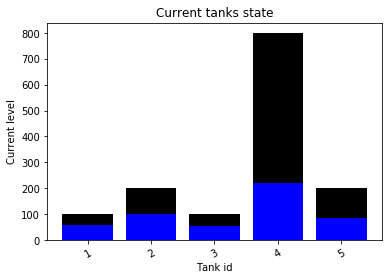

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

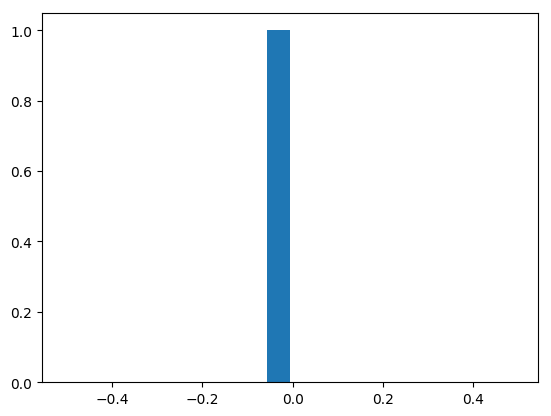

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

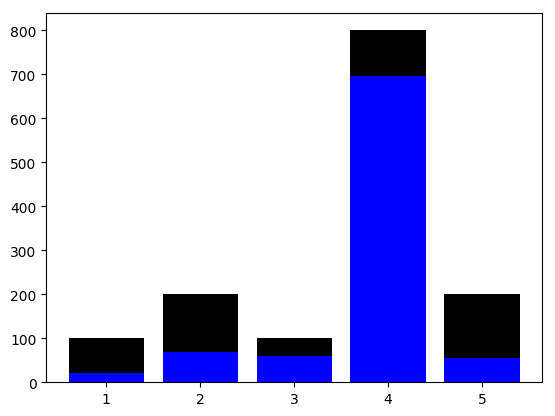

In [15]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


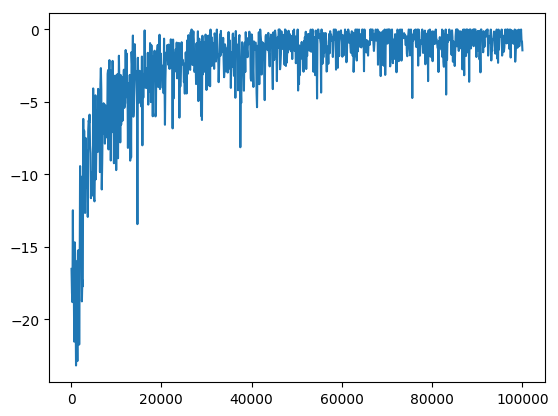

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [17]:
len(list(Q))

28342

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

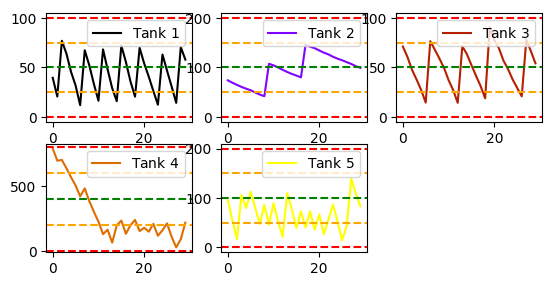

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

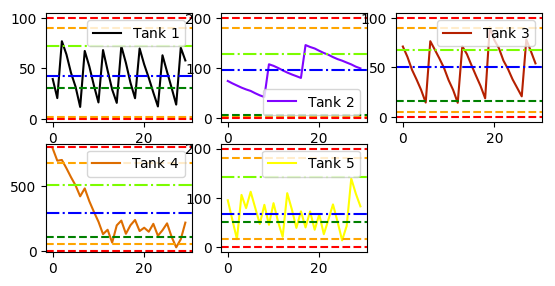

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

In [21]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [22]:
def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.0013346 -0.0001728 0.0011618 0300
Episode 1 t 2 -0.9999808 -0.9999808 0.0 5500
Episode 1 t 3 -0.0015925 2.79e-05 0.0016205 1400
Episode 1 t 4 0.0001598 0.0001598 0.0 5500
Episode 1 t 5 -0.0009451 0.0006863 0.0016313 2400
Episode 1 t 6 -7.3e-05 4.26e-05 0.0001156 0500
Episode 1 t 7 3.1e-05 3.1e-05 0.0 5500
Episode 1 t 8 1.77e-05 1.77e-05 0.0 5500
Episode 1 t 9 -0.0010827 0.0005269 0.0016096 4300
Episode 1 t 10 -0.0011377 2.42e-05 0.0011618 0300
Episode 1 t 11 -0.001428 0.0001816 0.0016096 4300
Episode 1 t 12 -0.0015436 8.77e-05 0.0016313 2300
Episode 1 t 13 0.0011245 0.0011245 0.0 5500
Episode 1 t 14 -0.0011292 3.26e-05 0.0011618 0400
Episode 1 t 15 -0.001585 2.47e-05 0.0016096 3300
Episode 1 t 16 1.23e-05 1.23e-05 0.0 5500
Episode 1 t 17 -0.0002516 0.001358 0.0016096 3300
Episode 1 t 18 -0.0005362 0.0006257 0.0011618 0400
Episode 1 t 19 -0.0016056 2.57e-05 0.0016313 2300
Episode 1 t 20 0.0006156 0.0006156 0.0

Episode 6 t 18 -0.0005631 0.0005987 0.0011618 0300
Episode 6 t 19 -0.0015983 2.22e-05 0.0016205 1400
Episode 6 t 20 -0.0016106 2.08e-05 0.0016313 2300
Episode 6 t 21 0.0005489 0.0005489 0.0 5500
Episode 6 t 22 -0.0007032 0.0004586 0.0011618 0300
Episode 6 t 23 -0.0015844 2.53e-05 0.0016096 4300
Episode 6 t 24 0.0003717 0.0003717 0.0 5500
Episode 6 t 25 -0.0009456 0.000664 0.0016096 4300
Episode 6 t 26 -0.0011384 2.34e-05 0.0011618 0400
Episode 6 t 27 -0.0016017 2.96e-05 0.0016313 2300
Episode 6 t 28 -0.0015197 8.99e-05 0.0016096 3300
Episode 6 t 29 0.0005824 0.0005824 0.0 5500
Test episode: 7
Episode 7 t 0 2.57e-05 2.57e-05 0.0 5500
Episode 7 t 1 -0.0015857 2.39e-05 0.0016096 3300
Episode 7 t 2 0.0005273 0.0005273 0.0 5500
Episode 7 t 3 -0.0012772 0.0003433 0.0016205 1400
Episode 7 t 4 -0.0011346 2.72e-05 0.0011618 0300
Episode 7 t 5 -0.0015829 2.67e-05 0.0016096 3300
Episode 7 t 6 -0.0015834 2.62e-05 0.0016096 4300
Episode 7 t 7 -0.0016101 2.12e-05 0.0016313 2300
Episode 7 t 8 0.00094

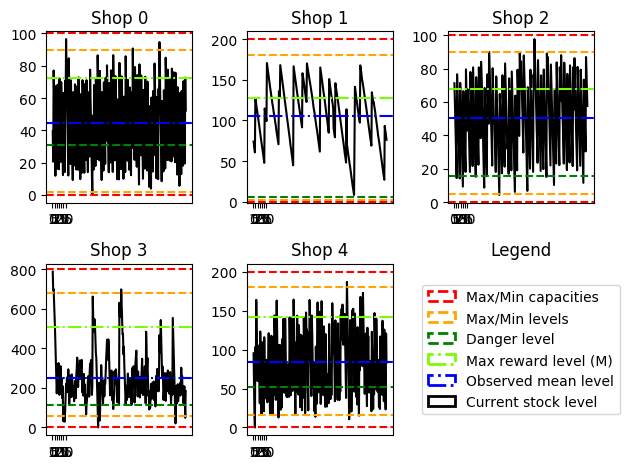

Total discounted rewards Level rewards Transport rewards
-0.12406842431676261 -0.2931876721623853 0.030071929580999985
Average trucks sent:  41.6


In [23]:
test_simulation(simulation_id= 16, max_episodes = 100000,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.0013346 -0.0001728 0.0011618 0300
Episode 1 t 2 -0.001021 2.52e-05 0.0010463 5400
Episode 1 t 3 1.95e-05 1.95e-05 0.0 5500
Episode 1 t 4 0.0004162 0.0004162 0.0 5500
Episode 1 t 5 -0.0009452 0.0006861 0.0016313 2400
Episode 1 t 6 -0.0023033 -0.0011013 0.0012021 0200
Episode 1 t 7 1.77e-05 1.77e-05 0.0 5500
Episode 1 t 8 -0.000102 0.0004722 0.0005742 1500
Episode 1 t 9 -0.0010809 0.0005288 0.0016096 4300
Episode 1 t 10 0.0001941 0.0003096 0.0001156 0500
Episode 1 t 11 -0.0015894 2.02e-05 0.0016096 4300
Episode 1 t 12 -0.0006271 0.0004192 0.0010463 5300
Episode 1 t 13 -0.0010752 0.0005344 0.0016096 4300
Episode 1 t 14 -0.0008319 0.0003702 0.0012021 0200
Episode 1 t 15 -0.0015879 2.18e-05 0.0016096 4300
Episode 1 t 16 -0.0012609 0.0003488 0.0016096 3300
Episode 1 t 17 -0.0001822 0.0003812 0.0005634 4500
Episode 1 t 18 0.0003626 0.0004781 0.0001156 0500
Episode 1 t 19 -0.0015926 1.7e-05 0.0016096 4300
Episode 1 t

Episode 6 t 16 -0.0007214 0.0008882 0.0016096 3300
Episode 6 t 17 -0.0011316 3.02e-05 0.0011618 0400
Episode 6 t 18 2.02e-05 2.02e-05 0.0 5500
Episode 6 t 19 -0.0010352 1.11e-05 0.0010463 5300
Episode 6 t 20 -0.0005909 0.0010404 0.0016313 2300
Episode 6 t 21 -0.0011291 3.28e-05 0.0011618 0400
Episode 6 t 22 -0.0015826 2.7e-05 0.0016096 3300
Episode 6 t 23 1.48e-05 1.48e-05 0.0 5500
Episode 6 t 24 -0.0004161 0.0011936 0.0016096 3300
Episode 6 t 25 -0.0011361 2.57e-05 0.0011618 0400
Episode 6 t 26 1.21e-05 1.21e-05 0.0 5500
Episode 6 t 27 -0.0016194 1.19e-05 0.0016313 2300
Episode 6 t 28 -4.43e-05 0.0015653 0.0016096 3300
Episode 6 t 29 -1.0016166 -0.9999869 0.0016298 4100
Test episode: 7
Episode 7 t 0 2.57e-05 2.57e-05 0.0 5500
Episode 7 t 1 5.23e-05 5.23e-05 0.0 5500
Episode 7 t 2 -0.0010823 0.0005273 0.0016096 3300
Episode 7 t 3 -0.0002276 0.0003358 0.0005634 4500
Episode 7 t 4 -0.0010231 0.0001387 0.0011618 0300
Episode 7 t 5 -0.0015866 2.31e-05 0.0016096 4300
Episode 7 t 6 0.0001925

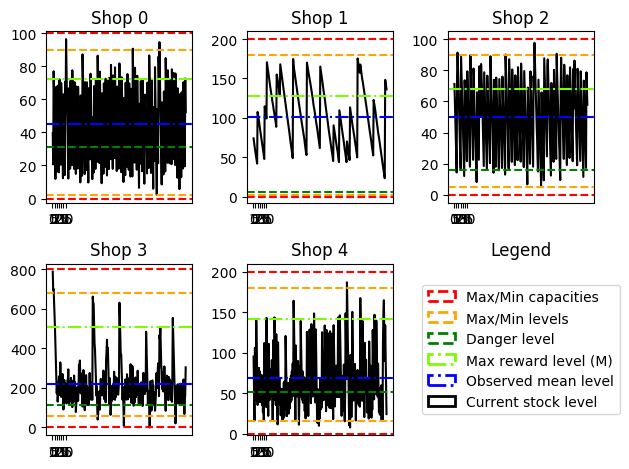

Total discounted rewards Level rewards Transport rewards
-0.06081330964573208 -0.19792093150096618 0.03042016883099998
Average trucks sent:  42.4


In [24]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.0013346 -0.0001728 0.0011618 0300
Episode 1 t 2 -0.9999808 -0.9999808 0.0 5500
Episode 1 t 3 -0.0003043 0.0002591 0.0005634 4500
Episode 1 t 4 -0.0004082 0.0001552 0.0005634 4500
Episode 1 t 5 0.0003194 0.0009044 0.000585 2500
Episode 1 t 6 -0.0011239 3.8e-05 0.0011618 0400
Episode 1 t 7 -0.0005421 3.22e-05 0.0005742 1500
Episode 1 t 8 1.88e-05 1.88e-05 0.0 5500
Episode 1 t 9 -0.0002829 0.0007634 0.0010463 5300
Episode 1 t 10 -0.0011331 2.87e-05 0.0011618 0400
Episode 1 t 11 -0.0008679 0.0001784 0.0010463 5300
Episode 1 t 12 -0.0015469 8.44e-05 0.0016313 2300
Episode 1 t 13 7.82e-05 0.0011245 0.0010463 5300
Episode 1 t 14 -0.0011292 3.26e-05 0.0011618 0400
Episode 1 t 15 -0.0010234 2.29e-05 0.0010463 5300
Episode 1 t 16 -0.0010325 1.38e-05 0.0010463 5300
Episode 1 t 17 0.0013545 0.0013545 0.0 5500
Episode 1 t 18 0.0003933 0.0011713 0.000778 4000
Episode 1 t 19 -1.001565 -0.9999554 0.0016096 4300
Episode 1 t 2

Episode 6 t 19 -0.0002208 0.0008255 0.0010463 5300
Episode 6 t 20 -0.0011409 0.0004904 0.0016313 2400
Episode 6 t 21 -0.0011323 2.95e-05 0.0011618 0300
Episode 6 t 22 0.0001748 0.0001748 0.0 5500
Episode 6 t 23 -0.0001317 0.0009146 0.0010463 5300
Episode 6 t 24 -0.0009864 0.0006232 0.0016096 4300
Episode 6 t 25 0.0006935 0.0008091 0.0001156 0500
Episode 6 t 26 -0.0015998 9.8e-06 0.0016096 4300
Episode 6 t 27 -0.000785 0.0008463 0.0016313 2300
Episode 6 t 28 5.85e-05 0.0006219 0.0005634 4500
Episode 6 t 29 0.001098 0.0013127 0.0002146 5000
Test episode: 7
Episode 7 t 0 -0.0005359 2.74e-05 0.0005634 3500
Episode 7 t 1 2.06e-05 2.06e-05 0.0 5500
Episode 7 t 2 -3.76e-05 0.0005258 0.0005634 3500
Episode 7 t 3 -0.0012721 0.0003376 0.0016096 4300
Episode 7 t 4 -0.0010214 0.0001405 0.0011618 0300
Episode 7 t 5 -0.0005418 2.16e-05 0.0005634 4500
Episode 7 t 6 -0.000852 0.0001943 0.0010463 5300
Episode 7 t 7 -0.0016139 1.74e-05 0.0016313 2400
Episode 7 t 8 -3.87e-05 0.0005247 0.0005634 3500
Epis

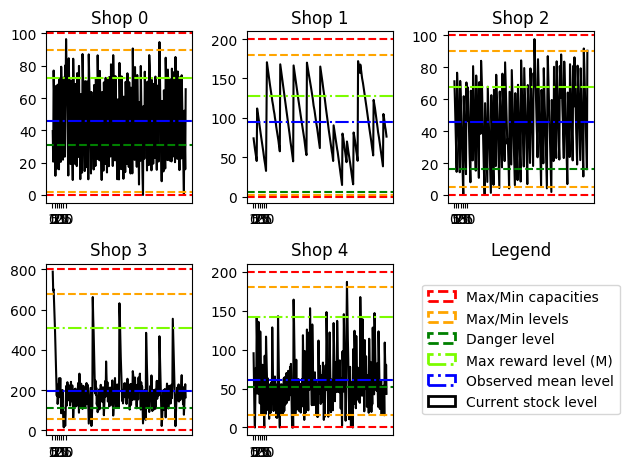

Total discounted rewards Level rewards Transport rewards
-0.269494764127751 -1.2062960712710864 0.029089121030999983
Average trucks sent:  40.0


In [25]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.0011299 3.19e-05 0.0011618 0400
Episode 1 t 2 3.14e-05 3.14e-05 0.0 5500
Episode 1 t 3 2.18e-05 2.18e-05 0.0 5500
Episode 1 t 4 -0.0001549 0.0004193 0.0005742 1500
Episode 1 t 5 -0.0009421 0.0006892 0.0016313 2400
Episode 1 t 6 -0.0011212 4.06e-05 0.0011618 0300
Episode 1 t 7 2.9e-05 2.9e-05 0.0 5500
Episode 1 t 8 -0.0015829 2.68e-05 0.0016096 4300
Episode 1 t 9 -3.67e-05 0.0005266 0.0005634 3500
Episode 1 t 10 -0.0008511 0.0003108 0.0011618 0300
Episode 1 t 11 -0.0014231 0.0001866 0.0016096 3400
Episode 1 t 12 -0.0015387 9.26e-05 0.0016313 2300
Episode 1 t 13 0.0005432 0.0005432 0.0 5500
Episode 1 t 14 -0.0005032 0.0006586 0.0011618 0300
Episode 1 t 15 -0.0015801 2.96e-05 0.0016096 3400
Episode 1 t 16 1.72e-05 1.72e-05 0.0 5500
Episode 1 t 17 -0.001229 0.0003806 0.0016096 4300
Episode 1 t 18 -0.0005364 0.0006254 0.0011618 0300
Episode 1 t 19 -0.0016036 2.77e-05 0.0016313 2400
Episode 1 t 20 2.27e-05 2.27e-05

Episode 6 t 18 -0.001584 2.57e-05 0.0016096 4300
Episode 6 t 19 1.33e-05 1.33e-05 0.0 5500
Episode 6 t 20 -0.0011464 0.0004849 0.0016313 2300
Episode 6 t 21 -0.0011287 3.32e-05 0.0011618 0400
Episode 6 t 22 -0.0015804 2.93e-05 0.0016096 3300
Episode 6 t 23 -0.0015876 2.2e-05 0.0016096 3300
Episode 6 t 24 0.000638 0.000638 0.0 5500
Episode 6 t 25 -0.0011346 2.73e-05 0.0011618 0400
Episode 6 t 26 1.44e-05 1.44e-05 0.0 5500
Episode 6 t 27 0.0003484 0.0009334 0.000585 2500
Episode 6 t 28 -0.0006032 0.0010065 0.0016096 3300
Episode 6 t 29 -0.1107223 -0.1095604 0.0011618 0300
Test episode: 7
Episode 7 t 0 -0.0015789 3.07e-05 0.0016096 3300
Episode 7 t 1 2.39e-05 2.39e-05 0.0 5500
Episode 7 t 2 -0.0010773 0.0005324 0.0016096 3300
Episode 7 t 3 -0.0006987 0.0003475 0.0010463 5400
Episode 7 t 4 -0.0011317 3.01e-05 0.0011618 0300
Episode 7 t 5 -0.0015758 3.38e-05 0.0016096 4300
Episode 7 t 6 2.21e-05 2.21e-05 0.0 5500
Episode 7 t 7 -0.0016152 1.61e-05 0.0016313 2300
Episode 7 t 8 -0.0011278 0.00

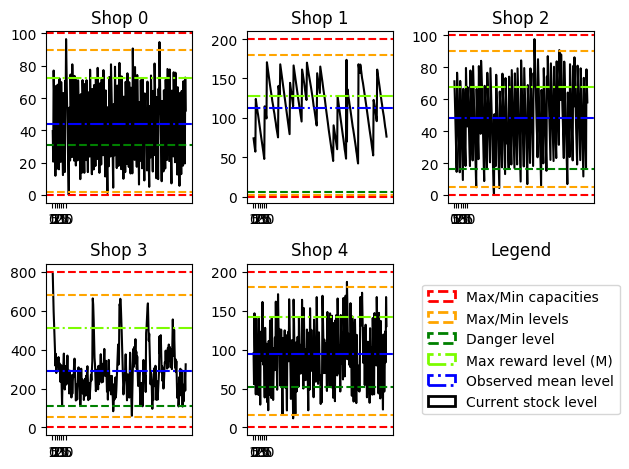

Total discounted rewards Level rewards Transport rewards
-0.07163915616123975 -0.2048540945878537 0.03076335216299998
Average trucks sent:  42.6


In [26]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.0013346 -0.0001728 0.0011618 0300
Episode 1 t 2 -0.001021 2.52e-05 0.0010463 5400
Episode 1 t 3 1.95e-05 1.95e-05 0.0 5500
Episode 1 t 4 -0.0004042 0.0001592 0.0005634 4500
Episode 1 t 5 9.44e-05 0.0006794 0.000585 2500
Episode 1 t 6 -0.0010011 0.0001608 0.0011618 0300
Episode 1 t 7 -0.0005364 2.7e-05 0.0005634 4500
Episode 1 t 8 -0.0003777 0.0001965 0.0005742 1500
Episode 1 t 9 -3.8e-05 0.0005254 0.0005634 4500
Episode 1 t 10 -8.82e-05 2.73e-05 0.0001156 0500
Episode 1 t 11 -2.28e-05 0.0010234 0.0010463 5300
Episode 1 t 12 -0.0007234 0.0009079 0.0016313 2400
Episode 1 t 13 -0.0010678 0.0005419 0.0016096 3300
Episode 1 t 14 -0.0007834 0.0003785 0.0011618 0300
Episode 1 t 15 -0.0005435 1.98e-05 0.0005634 4500
Episode 1 t 16 -0.0012812 0.0003393 0.0016205 1300
Episode 1 t 17 -0.0012336 0.000376 0.0016096 4300
Episode 1 t 18 -0.0017765 -0.0005745 0.0012021 0200
Episode 1 t 19 -0.0015864 2.32e-05 0.0016096 4300
E

Episode 6 t 15 -0.0015829 2.68e-05 0.0016096 4300
Episode 6 t 16 -0.0005402 2.32e-05 0.0005634 4500
Episode 6 t 17 -0.0012665 0.000354 0.0016205 1300
Episode 6 t 18 -0.0011206 4.13e-05 0.0011618 0300
Episode 6 t 19 -0.0005459 1.75e-05 0.0005634 4500
Episode 6 t 20 -0.0016153 1.6e-05 0.0016313 2300
Episode 6 t 21 -1.14e-05 0.000552 0.0005634 4500
Episode 6 t 22 -0.0011336 2.82e-05 0.0011618 0300
Episode 6 t 23 8.15e-05 0.0006449 0.0005634 3500
Episode 6 t 24 -0.0015257 8.4e-05 0.0016096 4300
Episode 6 t 25 0.0001022 0.0006656 0.0005634 4500
Episode 6 t 26 -0.0011411 2.07e-05 0.0011618 0300
Episode 6 t 27 -0.001053 0.0005783 0.0016313 2300
Episode 6 t 28 -0.0004799 8.34e-05 0.0005634 4500
Episode 6 t 29 -0.0005906 0.0005712 0.0011618 0300
Test episode: 7
Episode 7 t 0 -0.0005507 2.35e-05 0.0005742 1500
Episode 7 t 1 5.11e-05 5.11e-05 0.0 5500
Episode 7 t 2 -0.001586 2.36e-05 0.0016096 4300
Episode 7 t 3 -0.0012697 0.0003399 0.0016096 3300
Episode 7 t 4 -0.0011383 2.36e-05 0.0011618 0400


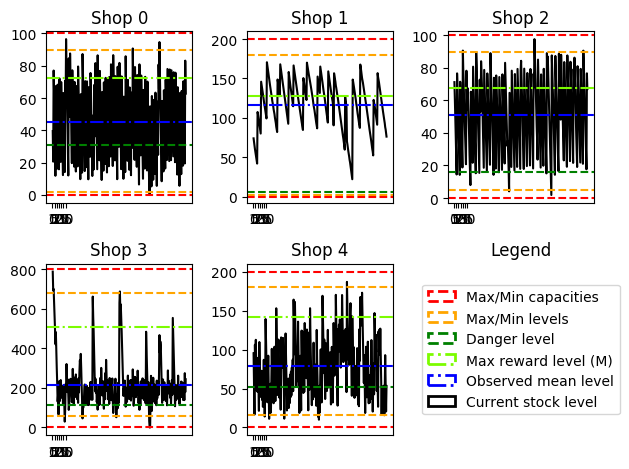

Total discounted rewards Level rewards Transport rewards
-0.14534638516837536 -0.2936295600290461 0.030049177949999988
Average trucks sent:  43.2


In [27]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes)